In [56]:
import numpy as np
import pandas as pd
import cPickle as pickle
from final_model_fit import *
from plot_confusion_matrix import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing
from matplotlib import colors as mcolors
import seaborn

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('../data/master.csv')
processed_df, X_train, X_test, y_train, y_test = process_frame(df)

/Users/Philip/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (13,23,28,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
mask_pass = df['PlayType'] == 'PASS'
mask_rush = (df['PlayType'] == 'RUSH') | (df['IsRush'] == 1)
passrush_df = df[mask_pass | mask_rush]

In [4]:
model_filename = '../models/gb_final.p'
model = pickle.load(open(model_filename, 'rb'))
model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=8000, presort='auto', random_state=None,
              subsample=1.0, verbose=2, warm_start=False)

In [5]:
def get_sorted_features(model, n_features):
    feature_importance = {}
    for label, importance in zip(processed_df.columns, model.feature_importances_):
        feature_importance[label] = importance

    return sorted(feature_importance.items(), key=lambda x: (-x[1]))[:n_features + 1]

get_sorted_features(model, 15)

[('ToGo', 0.071962741288327636),
 ('Left_in_game', 0.069232227240320507),
 ('Left_in_half', 0.064863929350025426),
 ('YardLine', 0.060312621872107265),
 ('Score_differential', 0.038412280641645175),
 ('Formation_UNDER CENTER', 0.027289984673762667),
 ('Away_total_score', 0.026836655341374412),
 ('Home_total_score', 0.025389802500948751),
 ('Formation_SHOTGUN', 0.020619944378100896),
 ('Last_two_plays_IsPass', 0.019397152301762612),
 ('Humidity', 0.017496017097208799),
 ('Temperature', 0.017488680962085112),
 ('Down_3', 0.015292632092559676),
 ('Quarter_4', 0.015070720647660806),
 ('Down_1', 0.014550729653982292),
 ('Wind', 0.013785032537357706)]

In [6]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

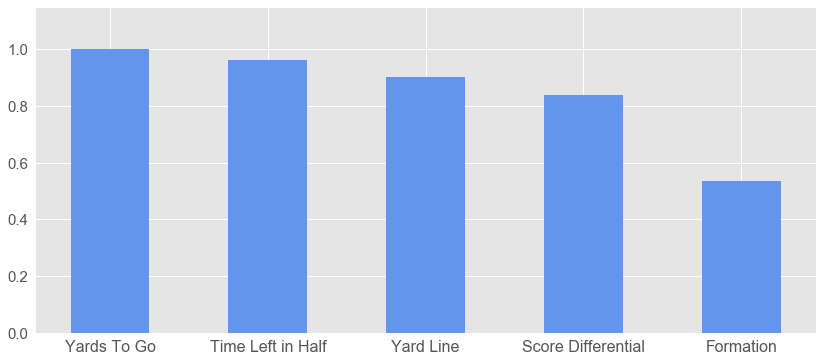

In [64]:
# plot relative feature importances
def plot_nfeature_importances(model, n_features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = list(processed_df.columns[indices])[:n_features]
    top_ten = importances[indices][:n_features]
    top_ten = top_ten / float(top_ten.max())
    fig, ax = plt.subplots(1, figsize=(14, 6))
    ax.set_ylim(0, 1.15)
    ax.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0], fontsize=15)
    fig_feature_names = ['', 'Yards To Go', 'Time Left in Half', 'Yard Line', 'Score Differential', 'Formation']
    ax.bar(range(1,len(fig_feature_names)), top_ten, width=0.5, align="center", color=colors['cornflowerblue'])
    ax.set_xticklabels(fig_feature_names, fontsize=16)
    plt.savefig('features.png', dpi=300)
    plt.show()

    
plot_nfeature_importances(model, 5)

In [8]:
# calculate pass play average by formation
shotgun_df = df[df['Formation'] == 'SHOTGUN']
undercenter_df = df[df['Formation'] == 'UNDER CENTER']
noh_shotgun_df = df[df['Formation'] == 'NO HUDDLE SHOTGUN']
noh_undercenter_df = df[df['Formation'] == 'NO HUDDLE']

formation_dfs = [shotgun_df, undercenter_df, noh_shotgun_df, noh_undercenter_df]
pass_ratios = [dataframe['IsPass'].mean() for dataframe in formation_dfs]
rush_ratios = [dataframe['IsRush'].mean() for dataframe in formation_dfs]

"""
Insights: 
- Only 23% of plays from under center result in a pass!
- Pass ratios for shotgun vs. no huddle shotgun are almost identical
- There are 28% more pass plays run out of no huddle under center plays vs. under center (with huddle)
    - This suggests that no huddle under center plays more often result in play action pass attempts
"""

'\nInsights: \n- Only 23% of plays from under center result in a pass!\n- Pass ratios for shotgun vs. no huddle shotgun are almost identical\n- There are 28% more pass plays run out of no huddle under center plays vs. under center (with huddle)\n    - This suggests that no huddle under center plays more often result in play action pass attempts\n'

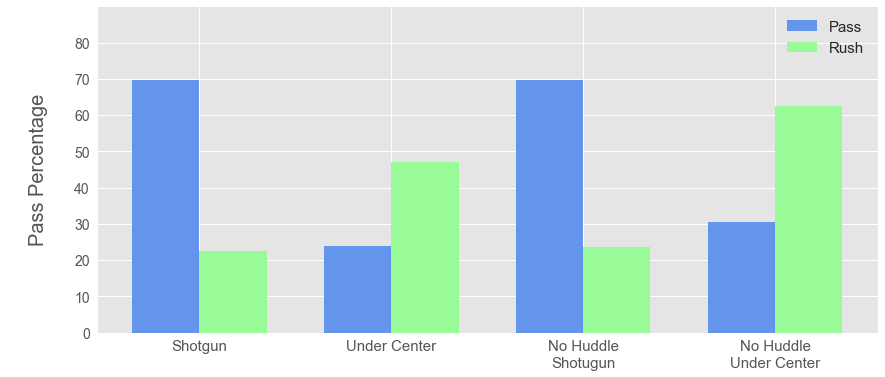

In [46]:
# plot pass play average by formation
def plot_formations(pass_ratios, rush_ratios):
    ind = np.arange(4)
    width = 0.35
    fig, ax = plt.subplots(figsize=(14, 6))
    rects1 = ax.bar(ind, pass_ratios, width, color=colors['cornflowerblue'])
    rects2 = ax.bar(ind + width, rush_ratios, width, color=colors['palegreen'])
    ax.set_ylim(0, 0.9)
    ax.set_yticklabels([0,10,20,30,40,50,60,70,80], fontsize=14)
    ax.set_ylabel('\nPass Percentage\n', fontsize=20)
#     ax.set_title('Pass/Rush Ratios by Formation')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('Shotgun', 'Under Center', 'No Huddle\nShotugun', 'No Huddle\nUnder Center'), fontsize=15)
    ax.legend((rects1[0], rects2[0]), ('Pass', 'Rush'), fontsize=15)
    plt.savefig('formation.png', dpi=300)
    plt.show()

plot_formations(pass_ratios, rush_ratios)

In [10]:
# Create absolute minute column
# q1 minute = absolute value of (minute - 15)
q1_mask = passrush_df['Quarter'] == 1.
passrush_df.loc[q1_mask, 'abs_minute'] = passrush_df['Minute'].apply(lambda x: abs(x-15))

q2_mask = passrush_df['Quarter'] == 2
passrush_df.loc[q2_mask, 'abs_minute'] = passrush_df['Minute'].apply(lambda x: abs(x-15) + 15)

q3_mask = passrush_df['Quarter'] == 3
passrush_df.loc[q3_mask, 'abs_minute'] = passrush_df['Minute'].apply(lambda x: abs(x-15) + 30)

q4_mask = passrush_df['Quarter'] == 4
passrush_df.loc[q4_mask, 'abs_minute'] = passrush_df['Minute'].apply(lambda x: abs(x-15) + 45)

q5_mask = passrush_df['Quarter'] == 5
passrush_df.loc[q5_mask, 'abs_minute'] = passrush_df['Minute'].apply(lambda x: abs(x-15) + 60)

/Users/Philip/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Philip/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


'\nInsights:\n- Across all quarters teams try to establish their run game, then open up through the air as time elapses\n- As time goes on pass attempts increase\n- Quarters 2 and 4 (before halves) experience much higher pass attempts on average\n- In the last minute of overtime over 90% of plays are pass attempts\n'

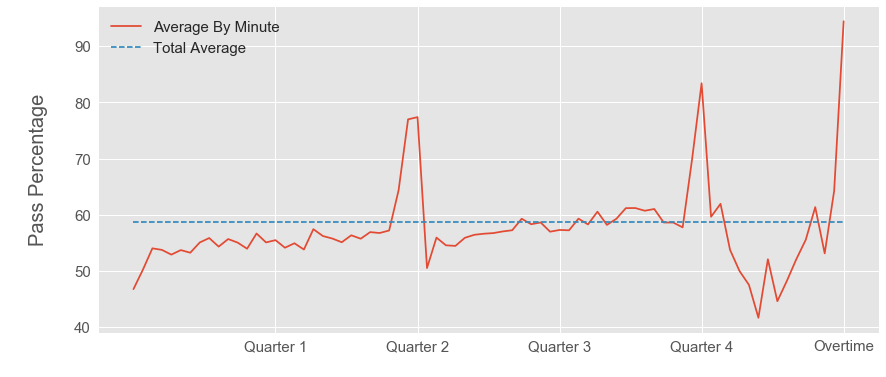

In [62]:
# Pass Play Average by Minute
fig, ax = plt.subplots(1, figsize=(14, 6))
ispass_df = passrush_df.groupby('abs_minute')['IsPass'].mean()
ax.plot(ispass_df.index, ispass_df, label='Average By Minute')
ax.plot(ispass_df.index, [0.5866371969545181]*76, label='Total Average', linestyle='dashed')
ax.set_title('\n\n', fontsize=22)
ax.set_ylabel('\nPass Percentage\n', fontsize=20)
ax.set_yticklabels([30,40,50,60,70,80,90], fontsize=15)
ax.set_xticks([15,30,45,60,75])
ax.set_xticklabels(['Quarter 1\n', 'Quarter 2', 'Quarter 3', 'Quarter 4', 'Overtime'], fontsize=15)
ax.legend(fontsize=15)
plt.savefig('time_wide.png', dpi=300)

"""
Insights:
- Across all quarters teams try to establish their run game, then open up through the air as time elapses
- As time goes on pass attempts increase
- Quarters 2 and 4 (before halves) experience much higher pass attempts on average
- In the last minute of overtime over 90% of plays are pass attempts
"""

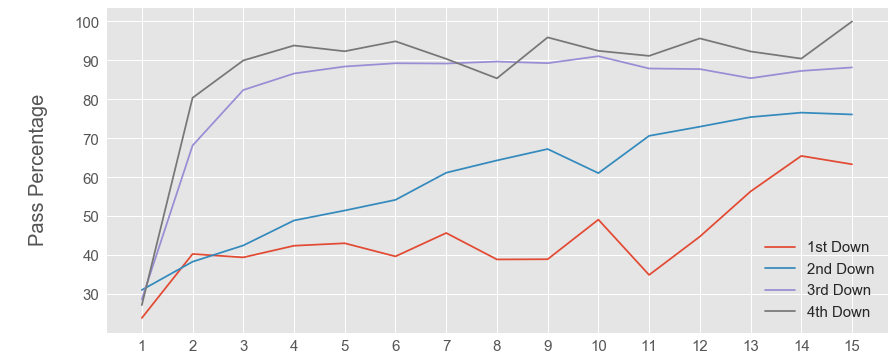

In [37]:
# Pass Play Average by Down and Distance
mask = (passrush_df['ToGo'] < 16) & (passrush_df['ToGo'] != 0)
downdistance_df = passrush_df[mask]
downdistance_df = downdistance_df.groupby(['ToGo','Down'])['IsPass'].mean().unstack()
fig, ax = plt.subplots(1, figsize=(14, 6))
ax.plot(downdistance_df.index, downdistance_df)
ax.set_xticks(range(1,16))
ax.set_xticklabels(range(1,16), fontsize=15)
# ax.set_xlabel('\nYards To First Down', fontsize=18)
ax.set_yticks(np.arange(0.3, 1.1, 0.1))
ax.set_yticklabels(np.arange(30, 110, 10), fontsize=15)
ax.set_ylabel('\nPass Percentage\n', fontsize=20)
ax.legend(['1st Down', '2nd Down', '3rd Down', '4th Down'], loc=4, fontsize=15)
plt.savefig('downanddistance.png', dpi=300)

/Users/Philip/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Philip/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


<Container object of 99 artists>

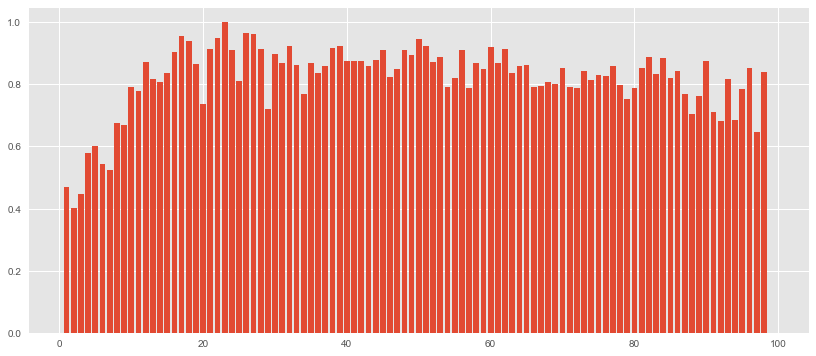

In [60]:
def normalize_col(df, col):
    mask = df[col].isnull()
    x = df[col].dropna().values.reshape(-1,1)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df.loc[~mask, col] = x_scaled
    return df

# Pass Play Average by Yardline
yardline_df = passrush_df.groupby('YardLine')['IsPass'].mean()
min_max_scaler = preprocessing.MinMaxScaler()
yardline_scaled = min_max_scaler.fit_transform(yardline_df)
yardline_scaled_series = pd.Series(yardline_scaled, index=range(1,100))
fig, ax = plt.subplots(1, figsize=(14, 6))
ax.bar(yardline_scaled_series.index, yardline_scaled_series)

In [13]:
# X_test = pickle.load(open('../models/X_test.p', 'rb'))
# y_test = pickle.load(open('../models/y_test.p', 'rb'))

In [14]:
# calculate evaluation metrics
accuracy, baseline, class_report, conf_matrix = return_model_scores(model, X_test, y_test)

Confusion matrix, without normalization
[[ 8931  4113]
 [ 3649 15250]]


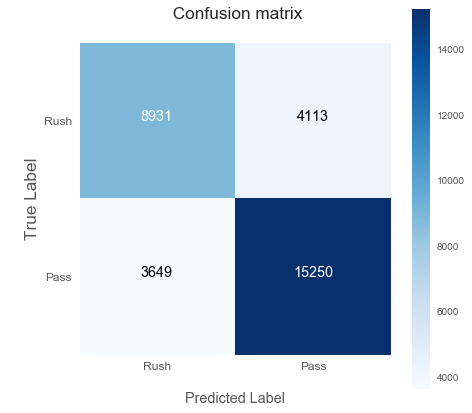

In [15]:
plt.figure(figsize=(7, 7))
plot_confusion_matrix(conf_matrix, classes=['Rush', 'Pass'], title=' Confusion matrix\n')
plt.savefig('confusion_matrix.png', dpi=300)

In [ ]:
# partial plots

In [ ]:
# roc_auc_score